# Implied Volatility

The implied volatility is a measure of market risk and is useful to determine changes in the supply and demand of a security. The implied volatility can be calculated from option prices using the Black-Scholes formula. This metric gives a forward-looking tool for the analyst. However, the implied volatility does not provide the direction of the change. When the market is bearish, the volatility tends to increase; on the other hand, when investors expect prices to rise, the implied volatility tends to fall.

This notebook will provide an algorithm to calculate the implied volatility for a given security using the call option chain. The algorithm first retrives the variables needed to calculate the call price with the Black-Scholes model assuming there is no dividend payment. Then, the algorithm estimates the spread between the calculated call price and the actual market price. Finaly, an optimization algorithm finds the implied volatility that makes the spread closest to zero.

Importing all necessary libraries first.

In [2]:
import yfinance as yf
from datetime import datetime
import quandl
import stockquotes
import numpy as np
import scipy.stats as st 
import pandas as pd 
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [18]:
#Dictionaries to customize the font of labels and titles
label_dict = {'fontsize': 14,
            'fontweight' : 5,
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'
             }
title_dict = {'fontsize': 20,
           'fontweight' : 5,
           'verticalalignment': 'baseline',
           'horizontalalignment': 'center'
             }

An option is a financial instrument that derives its value from an underlying asset. There are two types of option, calls and puts. A call option gives the holder the right to buy the underlying asset at a predetermined price, called strike price, on the expiration date of the call. A put option gives the holder the right to sell the underlying asset at the strike price on the expiration date.

In a call option, if at expiration the strike price is less than the spot price, the buyer of the option will have a positive return. Whereas, on a put option, the long side will benefit if the strike price is higher than the spot price. An option is in-the-money if the option provides a positive value, the option is out-of-the-money when it doesn't have intrinsic value; meaning that if the option is exercised, there is not going to be a profit. An option is at-the-money when the strike price is equal to the spot price of the underlying asset.

The price of the option is the premium that the long position must pay to bear the opportunity to buy or sell the underlying asset. The formula to calculate the call price for an European option that does not pay dividends is given by:

\begin{equation*}
C = S_t N \left(d1 \right) - K e^{-rt} N \left(d2 \right)
\end{equation*}

__Where:__

\begin{equation*}
d1 = \frac{ \ln{ \frac{S_t}{K} + \left(r + \frac{\sigma_u^2}{2} \right) t} }{\sigma_s \sqrt{t}}
\end{equation*}

and:

\begin{equation*}
d2 = d1 -  \sigma_s \sqrt{t}
\end{equation*}

__Where:__

\begin{alignat*}{1}
&C \quad & = \quad & \text{Call option price} \\
&S \quad & = \quad & \text{Current stock (or other underlying) price} \\
&K \quad & = \quad & \text{Strike price} \\
&r \quad & = \quad & \text{Risk-free interest rate} \\
&t \quad & = \quad & \text{time to maturity} \\
&\sigma \quad & = \quad & \text{Implied volatility} \\
&N \quad & = \quad & \text{A normal distribution}
\end{alignat*}

The target variable in the formula is sigma or the implied volatility.  

Before coding the algorithm to calculate the implied volatility, there are some helpful functions that must be defined. The first function is <code>Spot()</code> that retrives the current stock price given the ticker symbol. This function uses the module <code>stockquotes</code> that collects stock price data from Yahoo Finance.

In [3]:
def Spot(ticker):
    '''
    Takes a ticker symbol and returns the last price of the asset.
    
    Arguments:
    ticker -- String that represents the ticker symbol of the underlying asset. Refer to Yahoo Finance website to find 
              the symbol
              
    Returns:
    S -- Spot price of the asset
    '''
    
    security = stockquotes.Stock(ticker)
    S = security.current_price

    return S    

This analysis will focus on the S&P500 index because it doesn't pay dividends, one of the assumptions of the model. Furthermore, to get an accurate estimate of the forward-looking implied volatility, it is necessary to select strike prices that are at the money. 

Retriving the spot price of the S&P500 using the function define above:

In [5]:
S = Spot("^GSPC")
print(f'The last price of the S&P500 was ${S}, thus preferred strike prices are in the range of',end=" ") 
print(f'${round(S-300)} - ${round(S+300)}')

The last price of the S&P500 was $3709.41, thus preferred strike prices are in the range of $3409 - $4009


The next step would be to retrieve the strike price and the call premiun. The defined <code>call_data()</code> function gets these two pieces of information using the <code>yfinance</code> library. The requirements of the function are to specify a ticker symbol and the expiration date and returns a tuple with the strike price and call premium available for the expiration selected. 

The timeframe of the implied volatility analysis determines the most appropriate expiration date; for example, an analyst interested to investigate the forward-looking volatility in one year, should use options with an expiration of one year from now. In this notebook, the analysis will focus on options with maturity of one year.

In [6]:
def call_data(ticker,expiration):
    '''
    Extracts the strike price and call premium of an option given the ticker symbol of the underlying asset and 
    the expiration date. Returns a list of strike price and call premium.
    
    Arguments:
    ticker -- String that represents the ticker symbol of the underlying asset. Refer to Yahoo Finance website to find 
              the symbol
              
    expiration -- String date in format 'YYYY-MM-DD'. Refer to Yahoo Finance to check list of available expirations 
                  for the underlying asset
                  
    Returns:
    data -- list containig pairs of strike price and call premiums available for the underlying in the expiration 
            selected
    '''
    
    security = yf.Ticker(ticker)
    
    if expiration not in security.options:                       #Assertion to verify that expiration exists
        print('Option expiration not available, please verify')
        return
        
    options = security.option_chain(expiration)
    calls = options.calls
    strike_price = calls['strike']
    call_premium = calls['lastPrice']
    
    data = list(zip(strike_price, call_premium))
    data = np.array(data)

    
    return data

In [25]:
expiration = '2021-12-16'

data = call_data('^GSPC',expiration)
print(f'For expiration on {expiration} there are {len(data)} strike price available','\n')
print(f'The strike price of ${data[0][0]} has a call premium of ${data[0][1]}')
print(f'The strike price of ${data[2][0]} has a call premium of ${data[2][1]}')
print(f'The strike price of ${data[25][0]} has a call premium of ${data[25][1]}')
print(f'The strike price of ${data[50][0]} has a call premium of ${data[50][1]}')


For expiration on 2021-12-16 there are 51 strike price available 

The strike price of $900.0 has a call premium of $2755.29
The strike price of $1225.0 has a call premium of $1956.5
The strike price of $2525.0 has a call premium of $575.4
The strike price of $4000.0 has a call premium of $130.7


As the strike price increases, the call premium gets lower. This relationship is noticable in a graph:

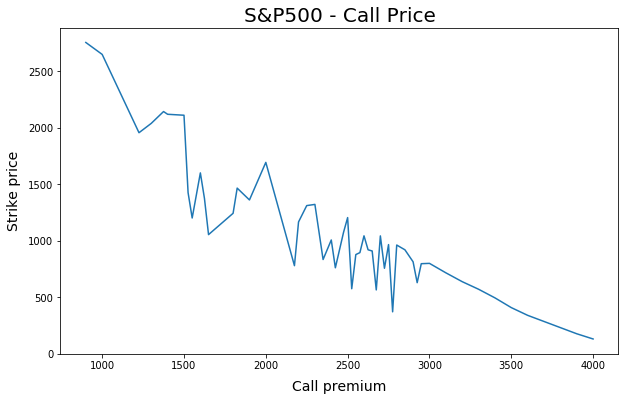

In [22]:
K, call_premium = list(zip(*data)) #unpacking the results of call_data function
K = np.array(K)
call_premium = np.array(call_premium)

# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.plot(K.tolist(), call_premium)

plt.title('S&P500 - Call Price', fontdict=title_dict)
plt.xlabel('Call premium',fontdict=label_dict,labelpad=20)
plt.ylabel('Strike price',fontdict=label_dict, labelpad=10)

plt.show()


The next variable to deteremine is the risk free rate. 

In [9]:
def Risk_free(ttm):
    '''
    Extracts the most recent US treasury rate given the time to maturity.
    
    Arguments:
    ttm -- Time to maturity in string format. The available options are:
           ['1 MO', '2 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']
    
    Returns:
    rf -- Most recent risk free rate for the time to maturity selected
    '''
    yield_curve = quandl.get('USTREASURY/YIELD', authtoken='JMxryiBcRV26o9r5q7uv')
    rf = yield_curve[ttm][-1]/100
    
    return rf    

In [10]:
Risk_free('1 YR')

0.0009

In [11]:
def Time_to_maturity(expiration):
    '''
    Calculates the time to maturity in years from today to the option expiration.
    
    Arguments:
    expiration -- String date in format 'YYYY-MM-DD'. Refer to Yahoo Finance to check list of available expirations 
                  for the underlying asset 
                  
    Returns:
    ttm -- Time to maturity in year in float format
    '''
    
    today = datetime.now()
    expiration_d = datetime.strptime(expiration,'%Y-%m-%d')
    datetime_delta = (expiration_d - today).days
    ttm = datetime_delta/365
    
    return ttm
    

In [12]:
Time_to_maturity('2021-12-16')

0.9972602739726028

In [13]:
def implied_vol(ticker, expiration, ttm, iterations = 25000):
    
    '''
    Optimization function that estimates the implied volatility of an option chain. 
    
    Arguments:                  
    ticker -- String that represents the ticker symbol of the underlying asset. Refer to Yahoo Finance website to 
              find the symbol
              
    expiration -- String date in format 'YYYY-MM-DD'. Refer to Yahoo Finance to check list of available expirations 
                  for the underlying asset  
                  
    ttm -- Time to maturity in string format. The available options are:
           ['1 MO', '2 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']
           
    iterations -- Number of times the algorithm has to run. The greater the number of iterations, the more accurate
                  result. Note that there is a trade off between computational cost and accuracy. recommended at least 
                  25,000 iterations. It might take a couple of minutes.
                  
    Returns:
    imply_vol -- Implied volatility that makes the difference between the market call price and the call price 
                 calculated using the Black-Scholes Model closest to zero. Numpy array of shape equal to number of 
                 strike price available for the option.
                 
    difference -- The closest to zero spread between the market call price and the call price calculated using the 
                  Black-Scholes Model. Numpy array of shape equal to number of strike price available for the option.
                  
    cache -- cache of values needed to calculate the call price with the Black-Scholes formula
                  
    '''
    # Retriving the current spot price
    S = Spot(ticker)
    S = np.array(S)
    
    # Retriving the array of strike price and market call price
    data = call_data(ticker,expiration)
    K, call_premium = list(zip(*data)) #unpacking the results of call_data function
    K = np.array(K)
    call_premium = np.array(call_premium)
      
    # Retriving the closest risk-free rate corresponding to the maturity of the option
    r = Risk_free(ttm)
    
    # Calculating the time to maturity of the option
    T = Time_to_maturity(expiration)
    print('Data downloaded successfully')
    # Creating a sample of random numbers representing the implied volatility distribution
    # The sample follows a normal distribution
    sigma_ran = np.random.randn(iterations)
    
    # Empty lists that will contain the minimun difference and the corresponding implied volatility
    imply_vol = []
    difference = []
    
    print('Starting to iterate')
    print('Please wait ...')
    # Loop through each strike price
    for i in range(0,len(K)):
        
        # Empty lists that will contain the positive spreads, the negative spreads, and their implied volatility
        spread_pos = []
        sigma_pos = []
        spread_neg = []
        sigma_neg = []
        
        # Loop through each value in the sample list of potential implied volatility
        for j in range(0,len(sigma_ran)):
            
            # Calculating the call price for each implied volatility given a specific strike price
            d1 = (np.log(np.divide(S,K[i]))+(r+((np.power(sigma_ran[j],2)/2))*T))/(sigma_ran[j]*np.sqrt(T))
            N_d1 = st.norm.cdf(d1)

            d2 = np.subtract(d1,sigma_ran[j]*np.sqrt(T))
            N_d2 = st.norm.cdf(d2)

            C = np.subtract(np.multiply(S,N_d1),np.multiply(K[i],np.multiply(np.exp(-r*T),N_d2)))
            
            # Calculating the spread between the previous calculation and the market call price
            spread = np.subtract(C, call_premium[i])
            
            # Separating the positive spreads with its volatility from the negative spreads with its volatility
            if spread >=0:
                spread_pos.append(spread)
                sigma_pos.append(sigma_ran[j])
            else:
                spread_neg.append(spread)
                sigma_neg.append(sigma_ran[j])
        
        # Finding the minimum positive spread and the index where it's located
        min_dif = np.min(spread_pos)
        index_min_dif = np.argmin(spread_pos)
        
        # Finding the maximum negative spread and the index where it's located
        max_dif = np.max(spread_neg)
        index_max_dif = np.argmax(spread_neg)
        
        # Comparing the maximum negative spread with the minimum positive spread and selecting the one with lowest
        # absolute value and identifying the corresponding implied volatility
        if abs(min_dif) < abs(max_dif):
            sigma_optimun = sigma_pos[index_min_dif]
            spr = min_dif
        else:
            sigma_optimun = sigma_neg[index_max_dif]
            spr = max_dif
        
        # Saving the implied volatility that makes the spread closest to zeroimply_vol, difference, cache = implied_vol('^GSPC','2021-12-16','1 YR',iterations=100000)

        imply_vol.append(sigma_optimun)
        difference.append(spr)
       
    # Values required to calculate the call price using Black-Scholes formula
    cache = (S,K,call_premium,r,T)
     
    return imply_vol, difference, cache

In [14]:
import time
tic = time.time()
imply_vol, difference, cache = implied_vol('^GSPC','2021-12-16','1 YR',iterations=100000)
toc = time.time()
print(toc-tic)

Data downloaded successfully
Starting to iterate
Please wait ...
1345.613482952118


In [15]:
print(imply_vol)

[0.172896467790924, 0.16444378426478856, 0.13881574459277696, 0.12743570300843987, 0.07088409719935165, 0.07088409719935165, 0.11009633373193864, 0.11360915801572406, 0.10945765941218236, 0.10545122959854461, 0.10359428393329582, 0.10123723171970171, 0.08976700331437515, 0.08849436358947832, 0.08377668947796381, 0.07609034467123554, 0.066127419885787, 0.03980706181270426, 0.062273937128303807, 0.05915022835615249, 0.057019625067267134, 0.05447648829516067, 0.05447648829516067, 0.050496363444218276, 0.17025460397063194, -0.0385742229618126, 0.03980706181270426, 0.0463515795523729, 0.04327706360907455, 0.04241876038528087, 0.04128852914423211, 0.04074079698454174, 0.03980706181270426, 0.037337592289397106, 0.18257421353905676, -0.032033419970837355, 0.23331448225504958, 0.033601784131491105, 0.03250931491122013, 0.14868642977061075, 0.029986392543803832, 0.2022354589770026, 0.20382167420163513, 0.19803098977673064, 0.22457490813177441, 0.2205265653837782, 0.21553555446666767, 0.190085411

In [16]:
print(difference)

[46.68741842487134, 45.52713158319011, 520.7689861894078, 363.0762710581473, 183.62355592688664, 182.82598421646662, 42.36569737478521, 751.8781256643649, 951.0605539539447, 501.8054105331046, 702.6278388226842, 998.1502671122639, 659.6848368497426, 411.8072651393222, 441.47455000806144, 64.96426316638076, 748.6212611934388, 336.5036894830189, 141.88854606217842, 81.4334026413378, 519.2782592204971, 296.323115799657, 517.4555440892367, 153.84040066839611, -0.0004272827586646599, -575.4, 275.77768553713565, 233.33011382671532, 59.8825421162951, 158.52497040587468, 144.04739869545438, 463.6698269850341, 43.59225527461422, 222.1146835641939, 0.0006424223415706365, -371.06, 0.008470903212241865, 63.84439672251267, 2.626825012092354, -0.008391727513185288, 149.7941098808319, -0.006078474393689248, -0.020078181844496612, -0.0048415195291227064, 0.010224859949971687, -0.018439065639995533, 0.00011976265614066506, -0.007599270512514522, -0.00819527223023897, 0.0009456529529359159, -0.030740554

In [17]:
S,K,call_premium,r,T = cache

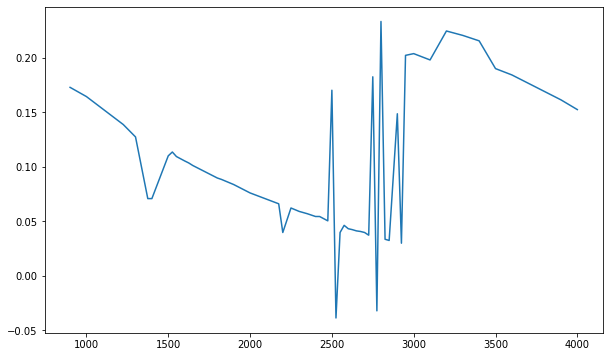

In [18]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.plot(K.tolist(), 
        imply_vol)


__References:__<p>&nbsp;</p> 

- Tim Worall (2008). The Black-Scholes Formula, FIN-40008 Financial Instruments http://www.timworrall.com/fin-40008/bscholes.pdf